<u>**Problem Statement**</u>.

The US Bike sharing company has to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know Which variables are significant in predicting the demand for shared bikes and How well those variables describe the bike demands.

<u>**Solutioning **</u>

To build a multiple linear regression to predict the demand for the shared bikes using the key driver variables.


IMPORT NECESSARY LIBRARIES

In [1]:
#Import Libraries
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score 
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings("ignore")

READ DATA AND INSPECT

In [3]:
day = pd.read_csv("day.csv") 
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
def get_shape(df):
    rows, columns = df.shape
    print(f"The given dataset contains {rows} rows and {columns} columns")

get_shape(day)

The given dataset contains 730 rows and 16 columns


### Data Understanding
The dataset has 730 observations and 16 variables, which gives us the following information

	
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not e)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered ( Target variable for prediction )


CHECK FOR MISSING AND DUPLICATE VALUES

In [5]:
def get_missing_values(df):
    return round(100*(df.isnull().sum()/len(df)), 2).sort_values(ascending=False)

In [6]:
# check the missing value % for each columm
get_missing_values(day)

cnt           0.0
registered    0.0
casual        0.0
windspeed     0.0
hum           0.0
atemp         0.0
temp          0.0
weathersit    0.0
workingday    0.0
weekday       0.0
holiday       0.0
mnth          0.0
yr            0.0
season        0.0
dteday        0.0
instant       0.0
dtype: float64

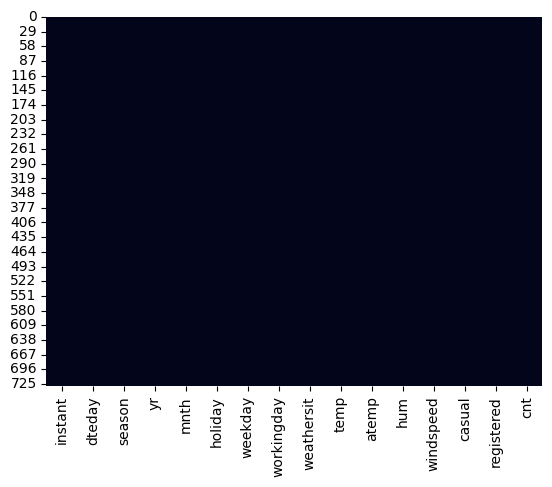

In [7]:
# visualize missing values, if any using a heatmap
import seaborn as sns
sns.heatmap(day.isnull(), cbar=False,  cbar_kws={"orientation": "horizontal"})
plt.show()


THE DATASET DOESNOT CONTAIN ANY MISSING VALUES :)

In [8]:
# Chec for duplicate rows 
row, column = day[day.duplicated()].shape
print('There are no duplicates in the dataset.' if row==0 else f'There are {row} duplicates in the dataset.')

There are no duplicates in the dataset.


In [9]:
def create_dist_box_plot(data, column_name, description):
    '''
    A re-usable function which creates a distribution plot
    and a box plot for numeric values. This will be used
    in our univariate analysis
    '''
    # sets the figure size and back ground style
    plt.figure(figsize=(15,8),facecolor='c')
    sns.set_style("dark")
    # plots the distribution plot on loan amount
    plt.subplot(2, 2, 1)
    ax = sns.distplot(data[column_name],rug = True)
    ax.set_title(f'{description} - Distribution Plot',fontsize=16, color='w')
    ax.set_xlabel(description,fontsize=14,color='w')

    # plots the box plot on loan amount
    plt.subplot(2, 2, 2)
    ax = sns.boxplot(x=data[column_name])
    ax.set_title(f'{description} - Box Plot', fontsize=16, color='w')
    ax.set_ylabel(description,fontsize=14,color='w')
    plt.show()

DESCRIBE THE STATS OF EACH COLUMNS PRESENT IN THE DATASET

In [10]:
day.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,730.0,365.500000,210.877136,1.000000,183.250000,365.500000,547.750000,730.000000
season,730.0,2.498630,1.110184,1.000000,2.000000,3.000000,3.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,2.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,23.726322,8.150308,3.953480,16.889713,24.368225,30.445775,42.044800


## Drop redundant and unwanted columns



- Casual and registered variable are just numbers and dont represent a factor that can affect our target variable "Cnt". If we add casual and registered users, it gives count . Also, the cnt, registered and casual follow roughly the same distribution.Hence we **drop** **casual** and **registered**
- Instant is just an index column, which is of no use . hence we can **drop** the `instant` column
- **dteday** is a date column, however they are represented by other columns like yr, mnth, holiday. Hence the the date column can **dropped**.


In [11]:
cols_to_drop = ['instant', 'dteday', 'casual', 'registered']
day = day.drop(cols_to_drop, axis = 1)

day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [12]:
# checking the shape of the df after dropping unwanted variables
get_shape(day)

The given dataset contains 730 rows and 12 columns


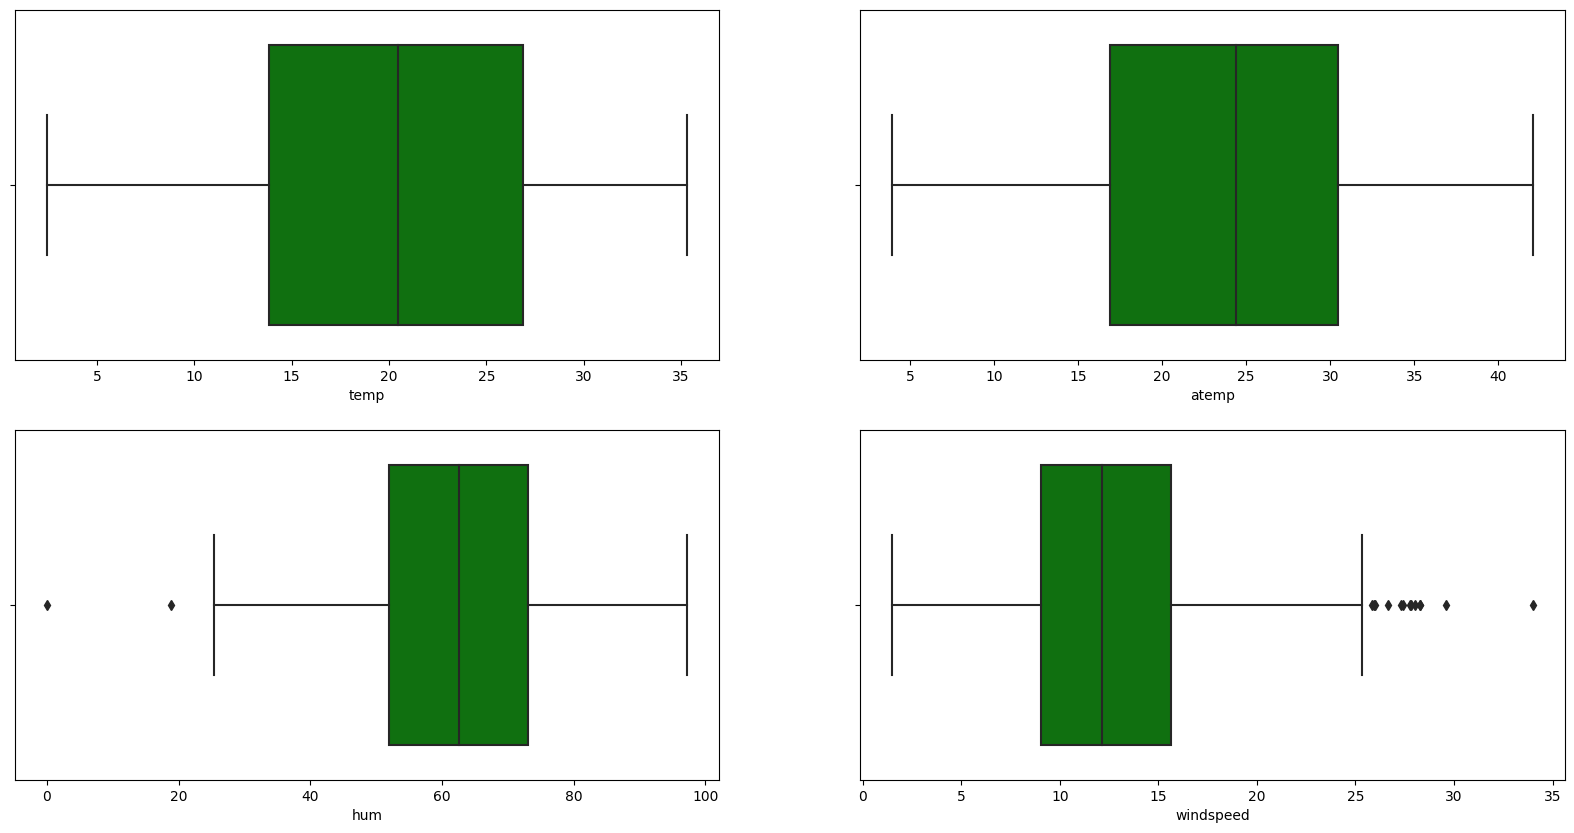

In [13]:
# Check for outliers in temp, atemp, hum, windspeed
plt.figure(figsize=(20, 10))


numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']

figure_num = 0
for feature in numerical_cols:
      figure_num = figure_num + 1
      plt.subplot(2,2, figure_num)
      sns.boxplot(x=day[feature],  color='green')

plt.show()      

HUM AND WINDSPEED SEEMS TO HAVE FEW OUTLIERS. LETS REMOVE THEM USING IQR

In [14]:
# Outlier treatment for hum and windspeed

outlier_features = ['hum','windspeed']
for feature in outlier_features:
    if day[feature].dtype!='O' and len(day[feature].unique())>2:
        lower_quartile = day[feature].quantile(0.25)
        upper_quartile = day[feature].quantile(0.75)
        median = day[feature].quantile(0.50)
        IQR = upper_quartile - lower_quartile
        lower_fence = lower_quartile - (1.5*IQR)
        upper_fence = upper_quartile + (1.5*IQR)
        
        day[feature] = np.where(day[feature] > upper_fence, 
                                median, 
                                day[feature])
        
        day[feature] = np.where(day[feature] < lower_fence,
                               median,
                               day[feature])

LETS CHECK THE DISTRIBUTION AFTER OUTLIER REMOVAL ON HUM AND WINDSPEED

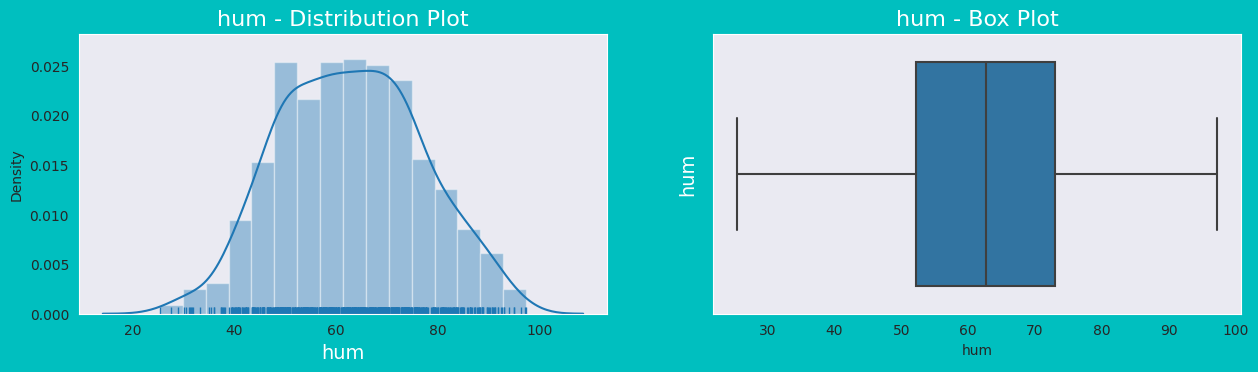

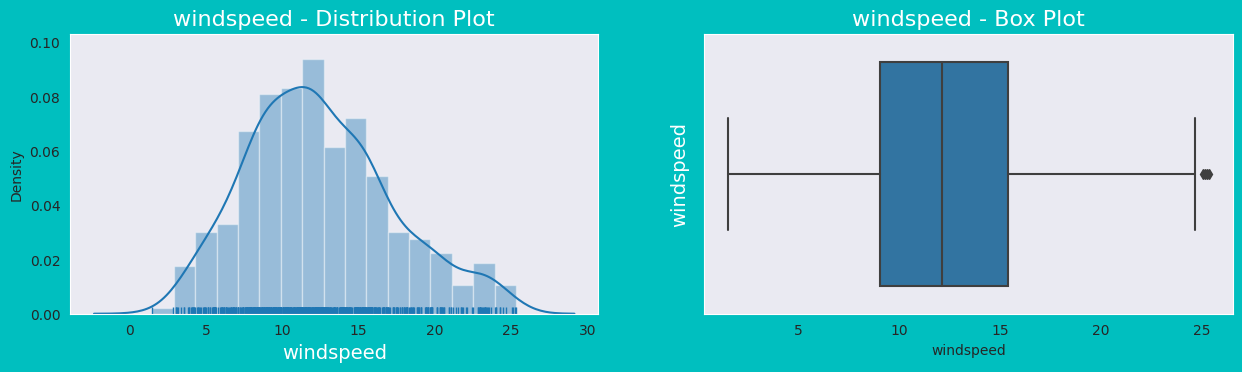

In [15]:
for feature in outlier_features:
    create_dist_box_plot(day, feature, feature)

THE BOX PLOT LOOKS PERFECT AFTER OUTLIER REMOVAL FOR WINDSPEED AND HUM. 

CHECK THE NUMBER OF UNIQUE VALUES
We are checking unique values as we found that the data type of our features are numerical .But we need to identify which among them is continuous numerical feature as we can not apply Multiple Linear Regression on categorical features.

In [16]:
day.nunique()

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           593
windspeed     636
cnt           695
dtype: int64

YEAR HAS 2 UNIQUE VALUES O REPRESENTING 2018 AND 1 REPRESENTING 2019
HOLIDAY HAS 2 UNIQUE VALUES INDICATING IF ITS A HOLIDAY OR NOT
WORKING DAY HAS 2 UNIQUE VALUES INDICATING IF ITS A WORKING DAY OR NOT

WE WONT BE CREATING DUMMIES FOR THESE VARIABLES AS IT WONT MAKE ANY SIGNIFICANCE

In [17]:
# map the categorical variables to its values and keep it in a different dataframe for analysis

data = day
data['season'] = data['season'].astype('category')
data['mnth'] = data['mnth'].astype('category')
data['weekday'] = data['weekday'].astype('category')
data['weathersit'] = data['weathersit'].astype('category')

data.season.replace( {1:"spring", 2:"summer", 3:"fall", 4:"winter"} ,inplace = True)
data.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'} ,inplace = True)

# Jan 1st of 2018 starts with monday and weekday is 6, jan 2nd 2018 is tuesday and weekday is 0.hence index starts from 0
data.weekday.replace({0: 'tue',1: 'wed',2: 'thu',3: 'fri',4: 'sat', 5:'sun', 6:'mon'},inplace = True)

data.weathersit.replace({1:'clear',2:'mist&cloudy',3:'LightSnow',4:'HeavyRain'},inplace = True)

data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,mon,0,mist&cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,0,mist&cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,clear,9.305237,11.46350,43.6957,12.522300,1600


In [18]:
categorical_features = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit']
numeric_features = ['temp', 'atemp', 'hum', 'windspeed'] 

In [19]:
def cat_bar_plot(dataframe, column):
    '''
    creates count plot for categorical variables
    '''
    print('\n\n')
    fig, ax = plt.subplots(figsize=(10,6)  , dpi=100)
    bg_color = '#ffd9d9'
    fig.set_facecolor(bg_color)
    sns.barplot(x=column, y='cnt', data=dataframe)
    ax.set_xlabel(column)
    ax.set_ylabel('Target - Cnt')
    ax.set_title('Plot of ' + column, weight='bold')
    plt.xticks(rotation=45)
    plt.show()

EDA -  ANALYSIS

UNIVARIATE ANALYSIS - UNDERSTAND THE TARGET VARIABLE

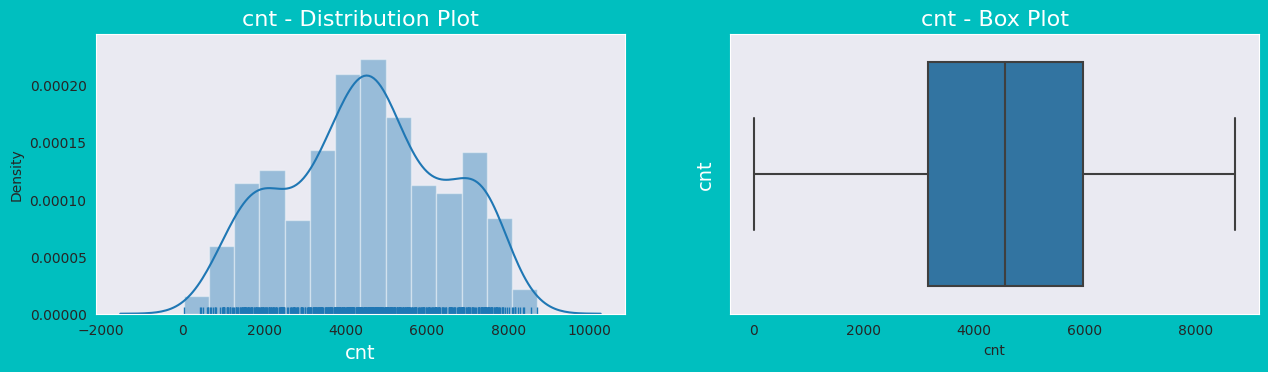

In [20]:
create_dist_box_plot(day, 'cnt', 'cnt')

THE TARGET VARIABLE IS NORMALLY DISTRIBUTED AND DOESNOT HAVE OUTLIERS

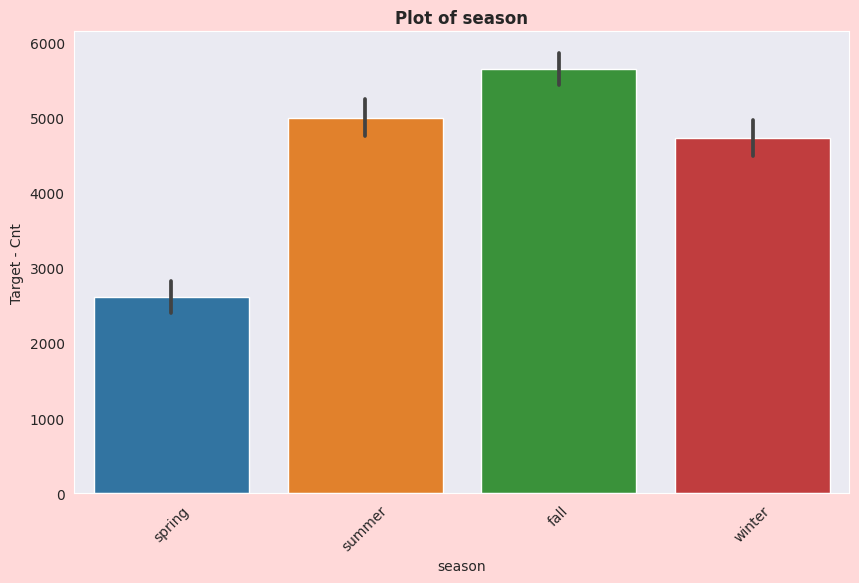

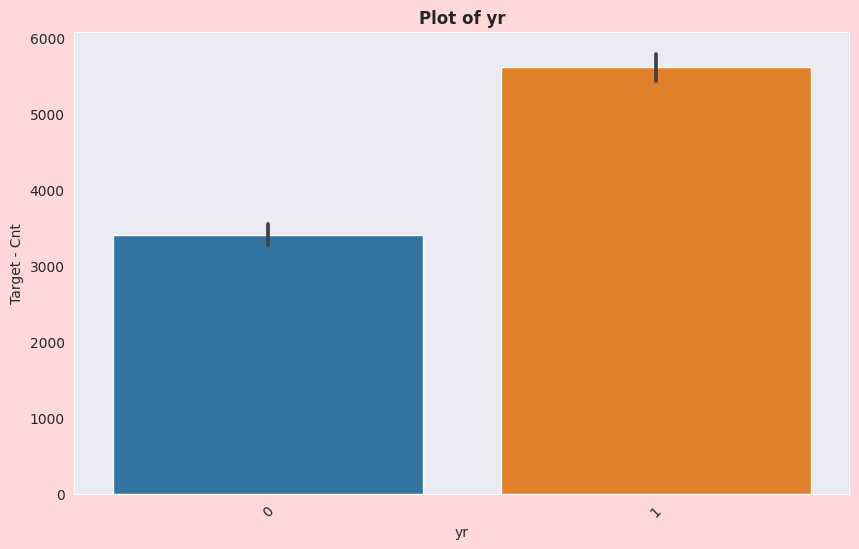

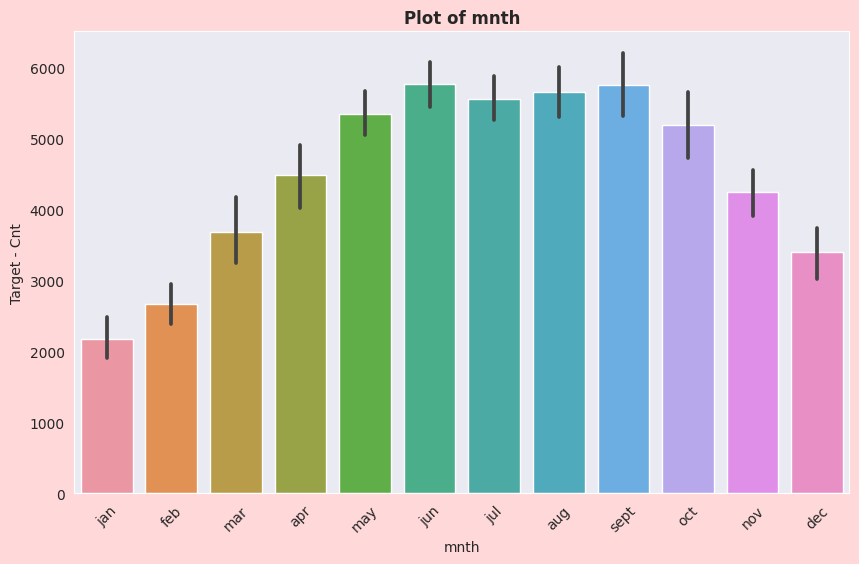

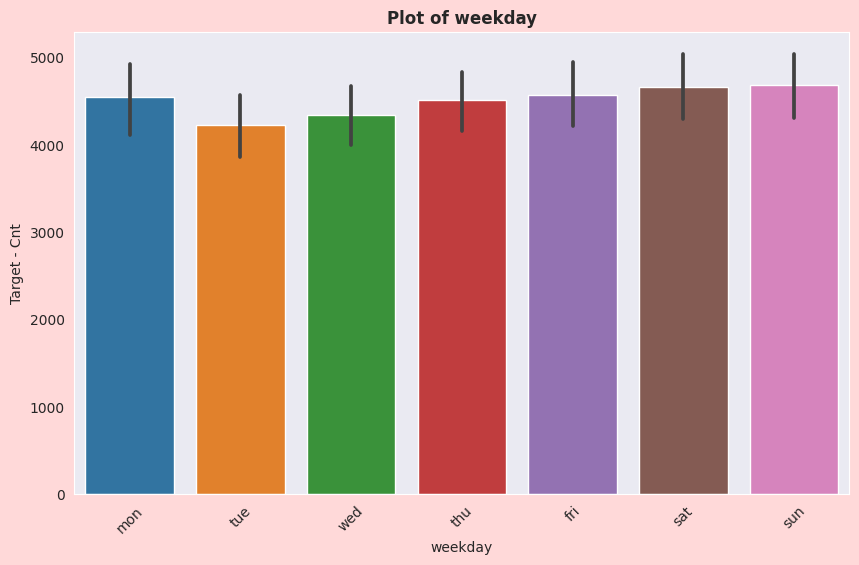

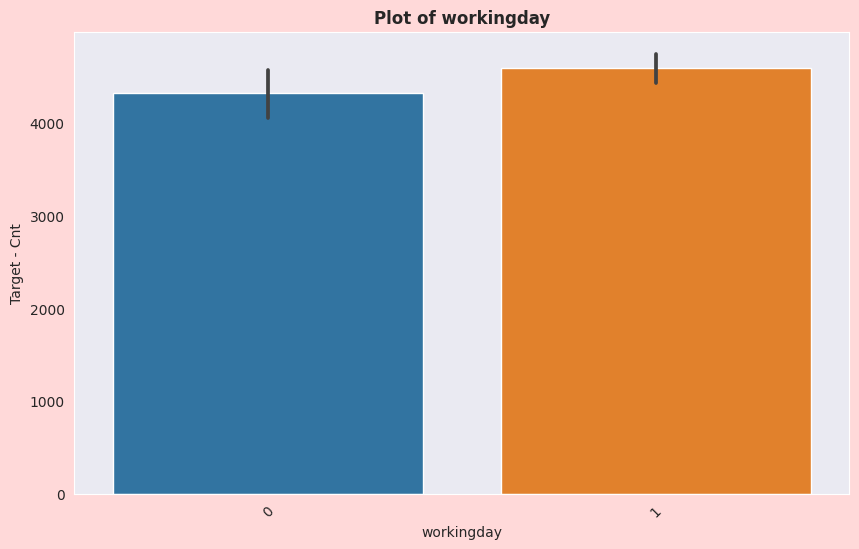

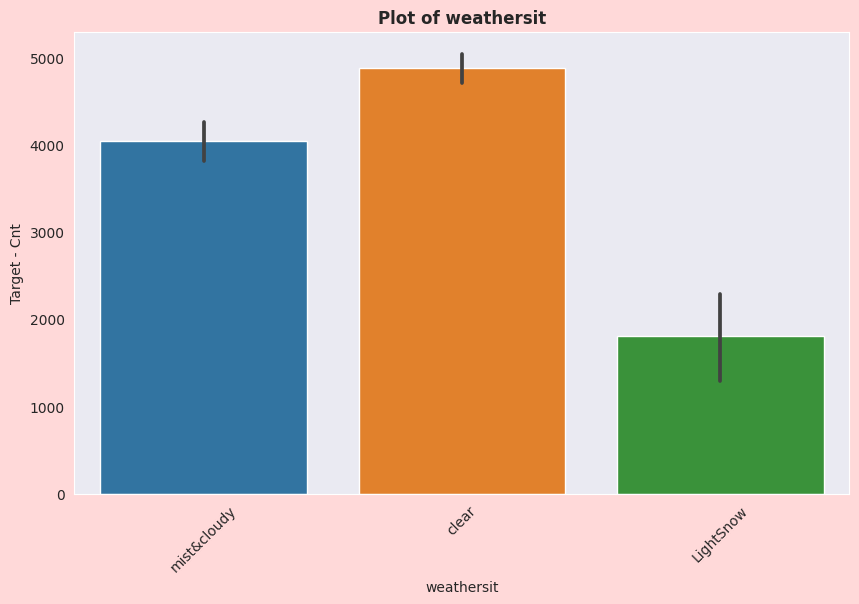

In [21]:

for feature in categorical_features:
    cat_bar_plot(data, feature)

plt.show()

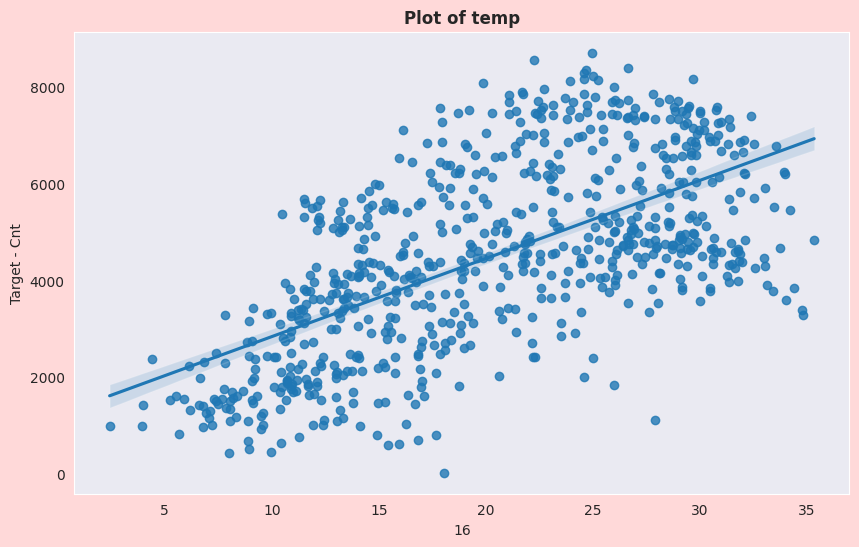

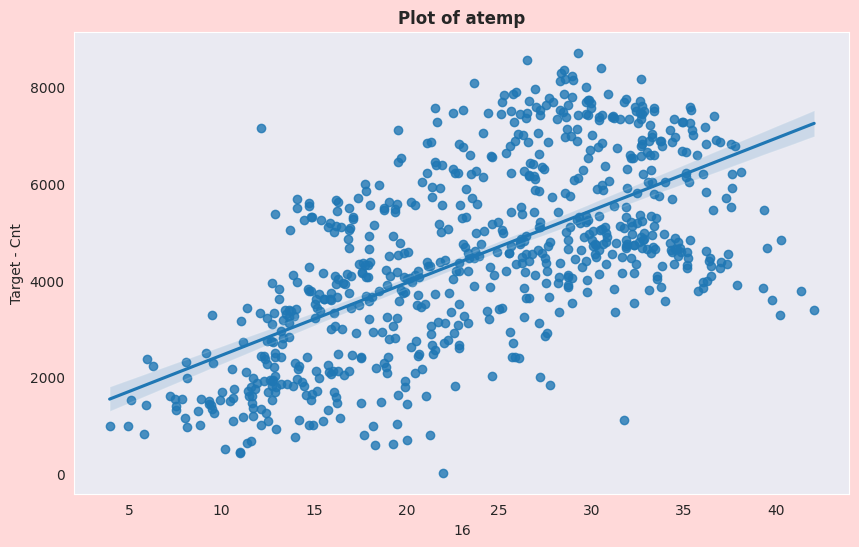

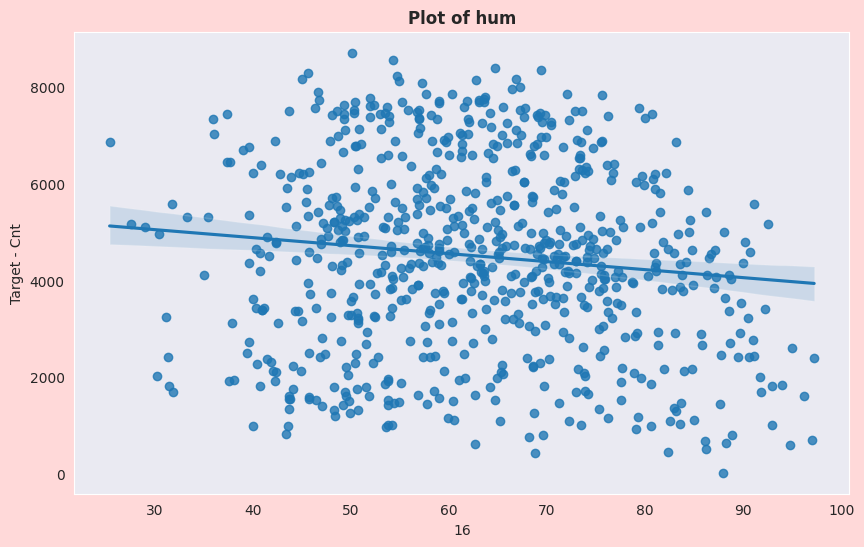

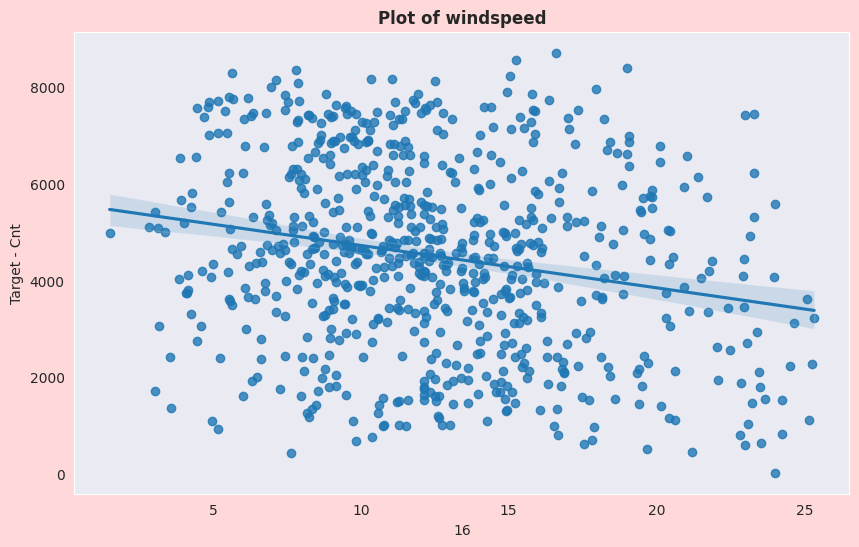

In [22]:
# visualizing the numeric features to know how they affect our target variable
for feature in numeric_features:
    fig, ax = plt.subplots(figsize=(10,6)  , dpi=100)
    bg_color = '#ffd9d9'
    fig.set_facecolor(bg_color)
    sns.regplot(data=data, x=feature, y="cnt")
    ax.set_xlabel(column)
    ax.set_ylabel('Target - Cnt')
    ax.set_title('Plot of ' + feature, weight='bold')
    plt.show()

### Inferences from plots
- Demand on **working days** is slightly **higher** 
- Demand for bikes has **increased** from **2018 to 2019**
- Demand for bikes is** high during the fall**, followed by summer, winter, spring
- May to Sept there is up trend in demand for bikes
- Demand for bikes increase with situation of weather.** Better the weather, higher the demand**
- Demand for bikes **increases** with the **rise** in **temp** and **atemp**
- Demand for bikes **decreases** with **increase** in **humidity** and **windspeed**

MULTIVARIATE ANALYSIS

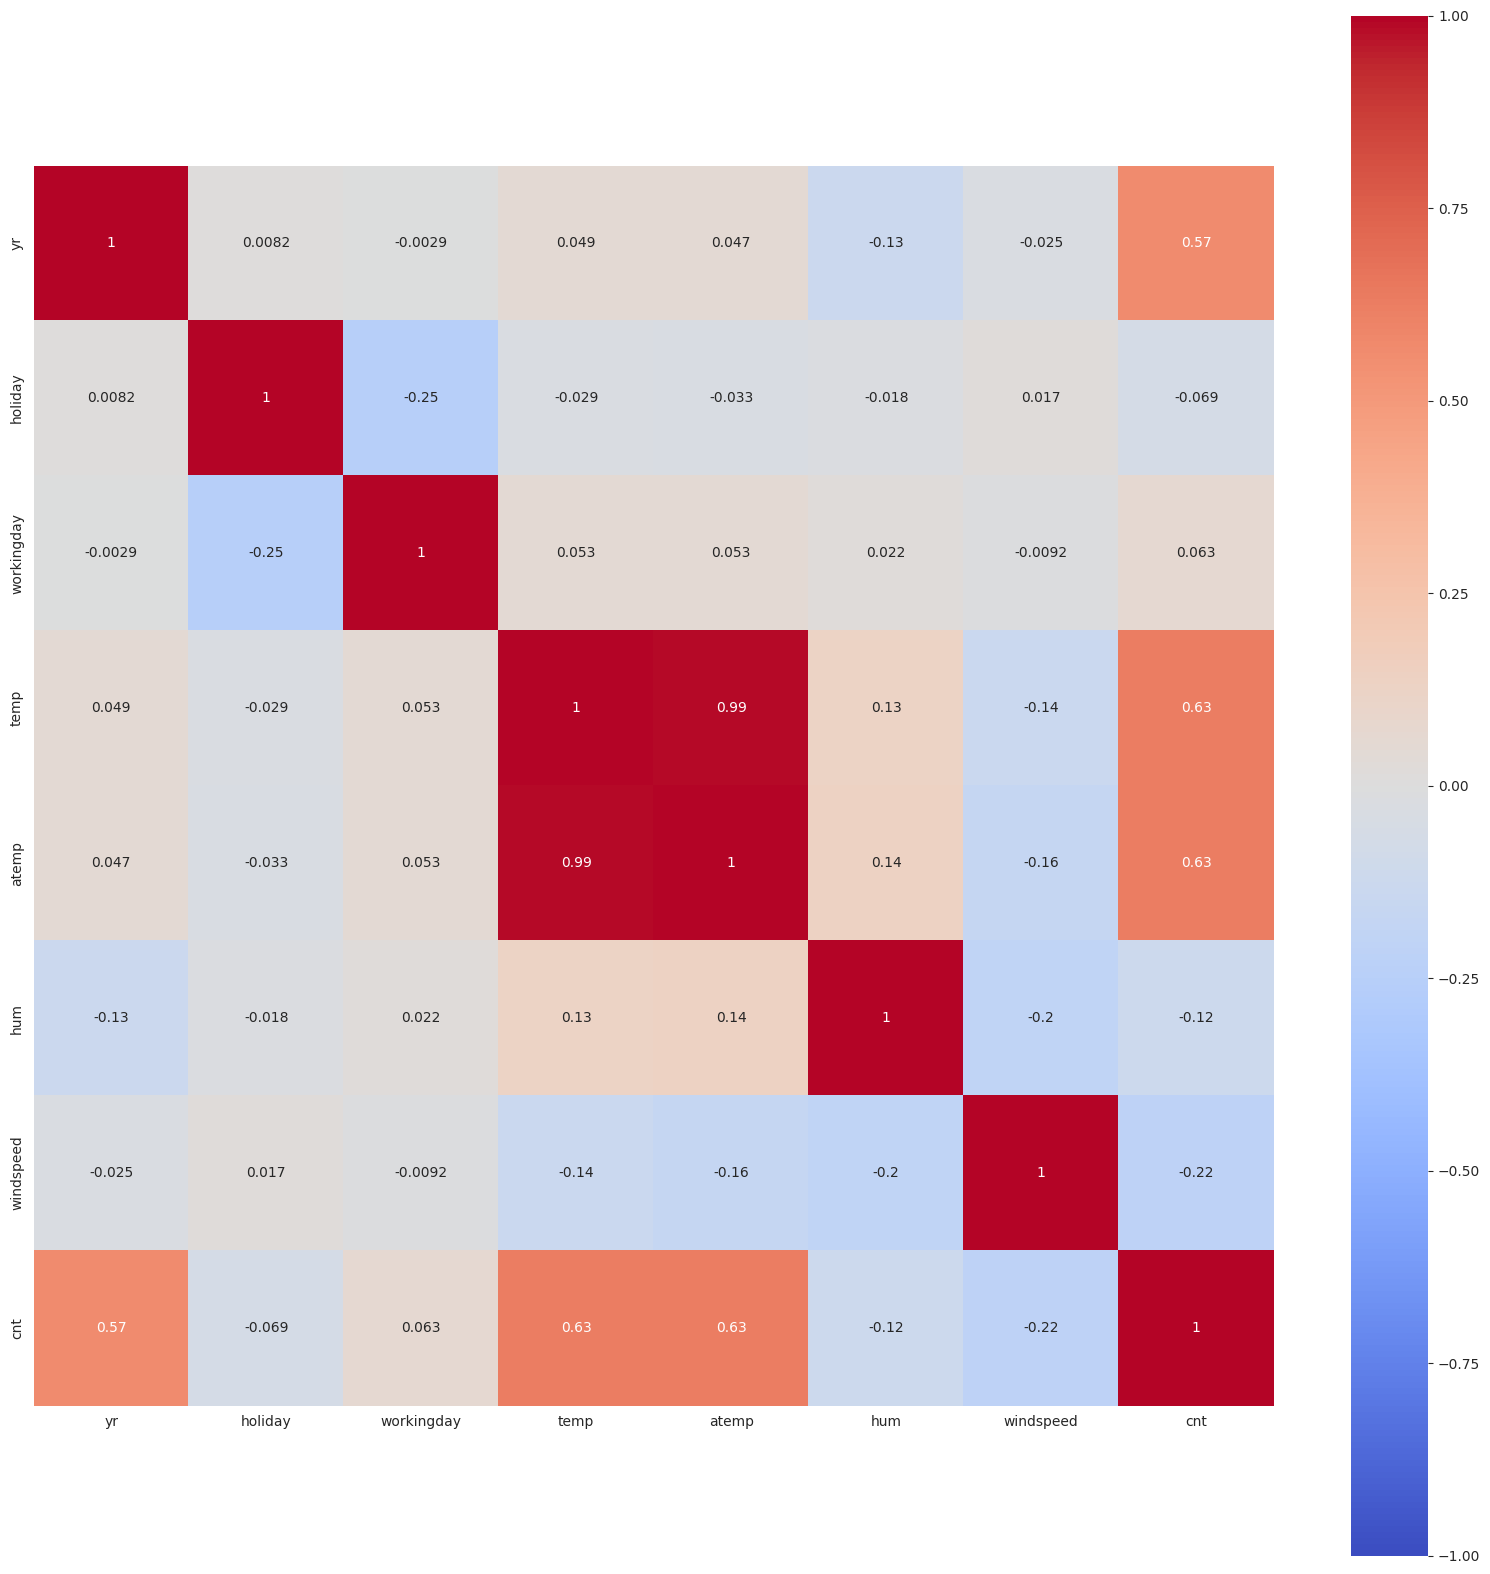

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(day.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True)

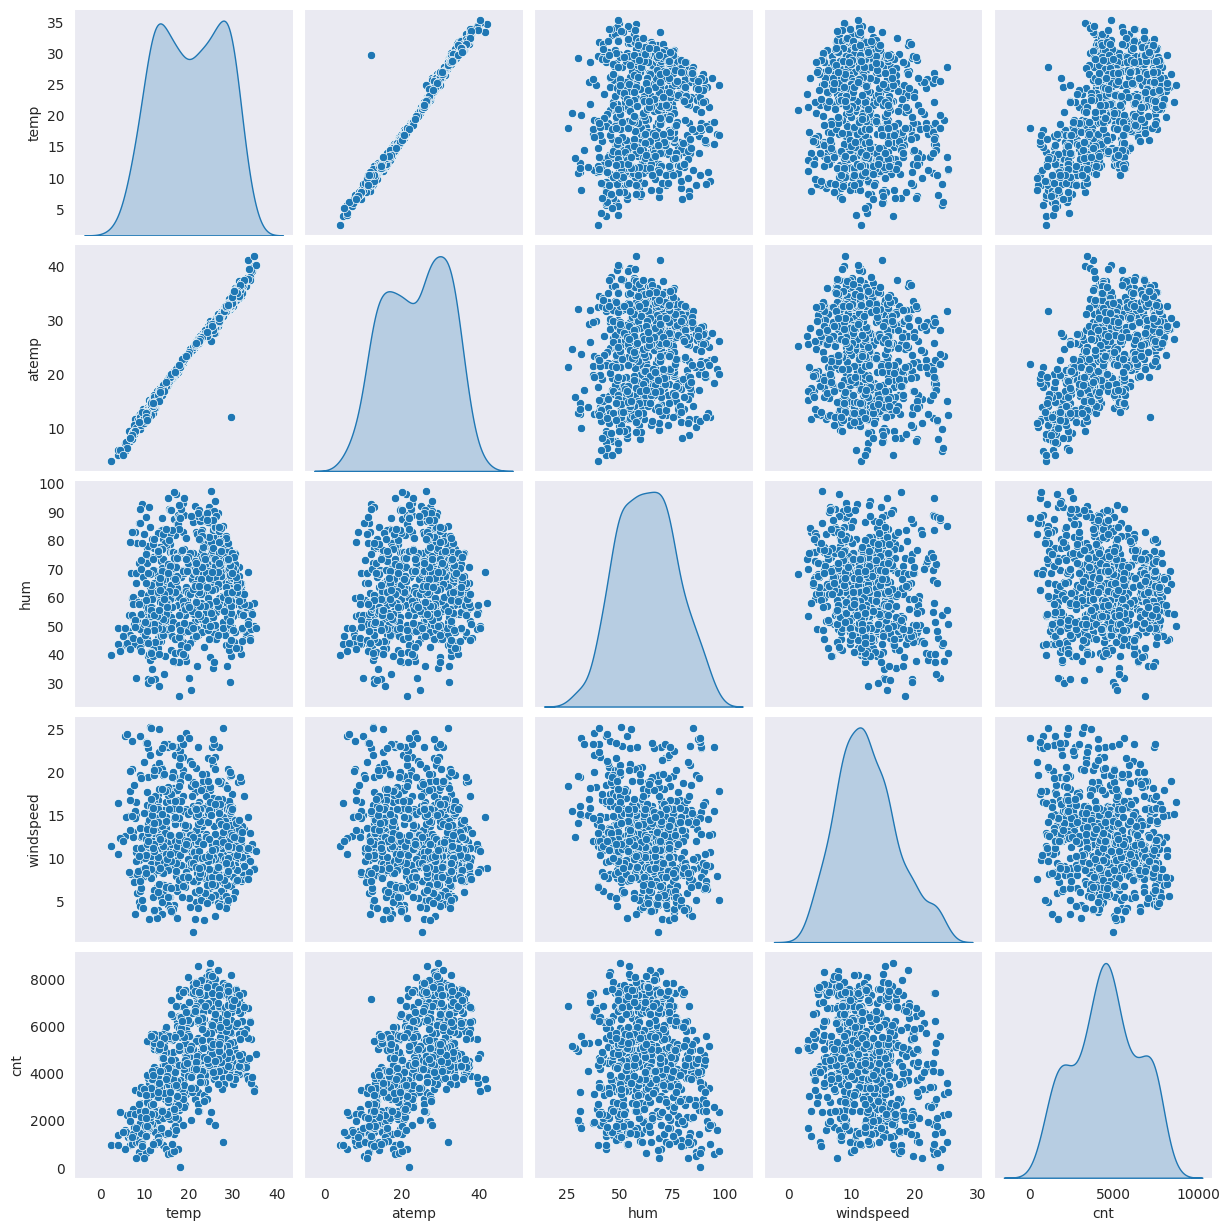

In [24]:
continuos_features = day[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sns.pairplot(continuos_features, diag_kind='kde')
plt.show()

INFERENCE OF MULTIVARIATE
- There is strong positive correlation between **cnt and temp** and **cnt and atemp** .
- There is strong correlation between atemp and temp. For now we will keep temp and atemp to see which one best useful while model building
- There is some sort of negative correlation between **cnt and humidity** and **cnt and windspeed**

**DATA PREPARATION AND MODEL BUILDING
**

**DATA TRANSFORMATION AND SCALING AND TRAIN TEST SPLIT**

In [25]:
data = pd.get_dummies(day, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   yr                      730 non-null    int64  
 1   holiday                 730 non-null    int64  
 2   workingday              730 non-null    int64  
 3   temp                    730 non-null    float64
 4   atemp                   730 non-null    float64
 5   hum                     730 non-null    float64
 6   windspeed               730 non-null    float64
 7   cnt                     730 non-null    int64  
 8   season_spring           730 non-null    uint8  
 9   season_summer           730 non-null    uint8  
 10  season_winter           730 non-null    uint8  
 11  mnth_aug                730 non-null    uint8  
 12  mnth_dec                730 non-null    uint8  
 13  mnth_feb                730 non-null    uint8  
 14  mnth_jan                730 non-null    ui

In [26]:
get_shape(data)

The given dataset contains 730 rows and 30 columns


In [27]:
# We should specify 'random_state' so that the train and test data set always have the same rows, respectively
# random state defines sampling you can write any number
np.random.seed(0)
data_train, data_test = train_test_split(data, train_size = 0.80, test_size = 0.20, random_state = 100)

In [28]:
# Shape of Train data
get_shape(data_train)

The given dataset contains 584 rows and 30 columns


In [29]:
# Shape of test data
get_shape(data_test)

The given dataset contains 146 rows and 30 columns


In [30]:
data.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_clear,weathersit_mist&cloudy
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [31]:
# Apply scaler() to all the columns on the train data except the 'yes-no' and 'dummy' variables
scaler = MinMaxScaler()
data_train[numeric_features] = scaler.fit_transform(data_train[numeric_features])
data_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_clear,weathersit_mist&cloudy
367,1,0,1,0.113228,0.061963,0.238153,0.962963,2236,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
648,1,0,1,0.468352,0.462175,0.269946,0.414801,7570,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
44,0,0,1,0.443431,0.419099,0.143971,0.412952,1913,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
705,1,0,1,0.326094,0.318824,0.703060,0.262939,5008,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
379,1,0,0,0.133996,0.108365,0.206359,0.622250,2311,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [32]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,584.0,0.513699,0.500241,0.0,0.000000,1.000000,1.000000,1.0
holiday,584.0,0.027397,0.163378,0.0,0.000000,0.000000,0.000000,1.0
workingday,584.0,0.667808,0.471403,0.0,0.000000,1.000000,1.000000,1.0
temp,584.0,0.537414,0.225336,0.0,0.340113,0.545191,0.736512,1.0
atemp,584.0,0.513175,0.211663,0.0,0.331819,0.530558,0.690521,1.0
hum,584.0,0.512932,0.196172,0.0,0.354979,0.516197,0.654019,1.0
windspeed,584.0,0.428094,0.211053,0.0,0.275902,0.408311,0.556506,1.0
cnt,584.0,4505.267123,1958.617712,22.0,3070.250000,4566.500000,6035.750000,8714.0
season_spring,584.0,0.251712,0.434369,0.0,0.000000,0.000000,1.000000,1.0
season_summer,584.0,0.246575,0.431387,0.0,0.000000,0.000000,0.000000,1.0


DIVIDING X AND Y SETS FOR MODEL BUILDING

In [33]:
y_train = data_train.pop('cnt')
X_train = data_train

In [34]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_clear,weathersit_mist&cloudy
367,1,0,1,0.113228,0.061963,0.238153,0.962963,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
648,1,0,1,0.468352,0.462175,0.269946,0.414801,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
44,0,0,1,0.443431,0.419099,0.143971,0.412952,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
705,1,0,1,0.326094,0.318824,0.703060,0.262939,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
379,1,0,0,0.133996,0.108365,0.206359,0.622250,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [35]:
y_train.head()

367    2236
648    7570
44     1913
705    5008
379    2311
Name: cnt, dtype: int64

In [36]:
# Create Linear regression model using sklearn to perform RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
# Reduce the  number features to 15 using automated approach
rfe = RFE(lr,15)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=15, step=1, verbose=0)

In [38]:
# List the RFE features along with ranking
list(zip(X_train.columns, rfe.support_ , rfe.ranking_))


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 5),
 ('season_winter', True, 1),
 ('mnth_aug', False, 10),
 ('mnth_dec', False, 2),
 ('mnth_feb', False, 4),
 ('mnth_jan', False, 3),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 11),
 ('mnth_mar', False, 14),
 ('mnth_may', False, 9),
 ('mnth_nov', True, 1),
 ('mnth_oct', False, 13),
 ('mnth_sept', True, 1),
 ('weekday_mon', True, 1),
 ('weekday_sat', False, 15),
 ('weekday_sun', False, 12),
 ('weekday_thu', False, 8),
 ('weekday_tue', False, 6),
 ('weekday_wed', False, 7),
 ('weathersit_clear', True, 1),
 ('weathersit_mist&cloudy', True, 1)]

In [39]:
# Filter RFE selected features
X_train_rfe = X_train.columns[rfe.support_ == True]

print(f'The features supported by rfe {X_train_rfe} and its shape is {X_train_rfe.shape}')

The features supported by rfe Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_spring', 'season_winter', 'mnth_jul', 'mnth_nov', 'mnth_sept',
       'weekday_mon', 'weathersit_clear', 'weathersit_mist&cloudy'],
      dtype='object') and its shape is (15,)


MANUAL ELIMINATION USING THE RESULTS FROM RFE

In [40]:
def build_linear_model(X_train, y_train):
    X_train_sm = sm.add_constant(X_train)
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [41]:
def calcualte_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)

    return vif

We will start building multiple linear regression model with 15 features and gradually eliminate the insignificant features based on **p- value** and **vif** and **adjusted r-square**

Below is the order of precedence for feature elimination

1) Remove features with high p-value, high vif - drop

2) In case of high- low

    a) Remove high p-value, low vif  first

    b) Remove low p , high vif - remove these later

3) Remove low p- value , low vif

**<u>MODEL 1</u>**

In the first model we will input all the features shortlisted by RFE using rfe.support

In [42]:
X_train_rfe = X_train[X_train_rfe]
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     206.4
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          1.96e-218
Time:                        15:14:22   Log-Likelihood:                -4710.5
No. Observations:                 584   AIC:                             9453.
Df Residuals:                     568   BIC:                             9523.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -83

In [43]:
# Calculate VIF
vif_model1 = calcualte_vif(X_train_rfe)
vif_model1

,Features,VIF
4,atemp,392.53
3,temp,386.84
13,weathersit_clear,13.17
5,hum,11.29
14,weathersit_mist&cloudy,7.67
2,workingday,5.07
6,windspeed,4.89
7,season_spring,3.20
8,season_winter,2.57
0,yr,2.11


<u>**OBSERVATIONS**</u>
 
- feature **atemp has high P-Value and high VIF**
- Hence in the next iteration of model, we will drop the atemp feature
- Adj- R-Square is 0.841

<u>**MODEL 2**</u>

For the second model we drop the atemp feature and check if it affects the adjusted R-squared significantly or not. 

In [44]:
X_train_rfe = X_train_rfe.drop(["atemp"], axis=1)
build_linear_model(X_train_rfe,  y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     220.7
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          3.39e-219
Time:                        15:14:23   Log-Likelihood:                -4711.5
No. Observations:                 584   AIC:                             9453.
Df Residuals:                     569   BIC:                             9519.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -83

In [45]:
vif_model2 = calcualte_vif(X_train_rfe)
vif_model2

,Features,VIF
3,temp,19.16
12,weathersit_clear,12.85
4,hum,11.14
13,weathersit_mist&cloudy,7.56
2,workingday,5.07
5,windspeed,4.73
6,season_spring,3.19
7,season_winter,2.56
0,yr,2.11
11,weekday_mon,1.91


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square remains the same after removing the atemp.
- The P-value of holiday is high, hence we can remove it in the next model
- Adj- R-Square is 0.841


<u>**MODEL 3**</u>

In this model we will remove the holiday feature and check if the adjusted r-square drops significantly. Then we will check for multi-collinearity using the VIF values.

In [46]:
X_train_rfe = X_train_rfe.drop( ["holiday"] , axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     235.7
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          2.40e-219
Time:                        15:14:24   Log-Likelihood:                -4714.0
No. Observations:                 584   AIC:                             9456.
Df Residuals:                     570   BIC:                             9517.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -130

In [47]:
vif_model3 = calcualte_vif(X_train_rfe)
vif_model3

,Features,VIF
2,temp,19.12
11,weathersit_clear,12.75
3,hum,11.13
12,weathersit_mist&cloudy,7.51
4,windspeed,4.70
1,workingday,4.49
5,season_spring,3.16
6,season_winter,2.56
0,yr,2.10
10,weekday_mon,1.78


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.840, which is very negligible drop and hence the holiday is insignificant .
- The P-value of mnth_nov is high, hence we can remove it in the next model
- Adj- R-Square is 0.840


<u>**MODEL 4**</u>

In this model, we will be dropping the mnth_nov and check the adjusted r-square, p-values and vif

In [48]:
X_train_rfe = X_train_rfe.drop( [ "mnth_nov" ], axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     252.2
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          4.11e-219
Time:                        15:14:25   Log-Likelihood:                -4717.4
No. Observations:                 584   AIC:                             9461.
Df Residuals:                     571   BIC:                             9518.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -187

In [49]:
vif_model4 = calcualte_vif(X_train_rfe)
vif_model4

,Features,VIF
2,temp,18.86
10,weathersit_clear,12.57
3,hum,11.13
11,weathersit_mist&cloudy,7.46
4,windspeed,4.66
1,workingday,4.48
5,season_spring,3.13
6,season_winter,2.17
0,yr,2.10
9,weekday_mon,1.77


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.838, which is very negligible drop and hence the holiday is insignificant .
- The P-value of mnth_nov is high, hence we can remove it in the next model
- Adj- R-Square is 0.838
- All the P-Values now look good . Hence we go with the VIF. The temp and weathersit_good has high VIF followed by hum. From our intuition on EDA we know the temp and weathersit_good are driving factors for demand. Also dropping the temp and weathersit_good reduces the r-square drastically.
- Hence we can try removing the hum with high VIF

<u>**MODEL 5**</u>

In this model we will try removing the hum feature as the temp and weathersit_good has very good co-efficient and are relevant to our target variable prediction from the EDA

In [50]:
X_train_rfe = X_train_rfe.drop( ["hum"] , axis = 1 )
build_linear_model( X_train_rfe, y_train )

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     267.8
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          2.36e-217
Time:                        15:14:26   Log-Likelihood:                -4724.4
No. Observations:                 584   AIC:                             9473.
Df Residuals:                     572   BIC:                             9525.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -914

In [51]:
vif_model5 = calcualte_vif(X_train_rfe)
vif_model5

,Features,VIF
2,temp,13.52
9,weathersit_clear,12.52
10,weathersit_mist&cloudy,7.02
3,windspeed,4.66
1,workingday,4.42
4,season_spring,2.73
0,yr,2.08
8,weekday_mon,1.77
5,season_winter,1.76
6,mnth_jul,1.38


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.834, which is very negligible drop and hence the hum is insignificant as per our intuition.
- The P-value of mnth_sep is high, hence we can remove it in the next model
- Adj- R-Square is 0.834


<u>**MODEL 6**</u>

Dropping the mnth_sept, which has high P-value although the VIF is less. This is insignificant for our model derivation.

In [52]:
X_train_rfe = X_train_rfe.drop( ["mnth_sept"], axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     288.2
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          3.89e-216
Time:                        15:14:27   Log-Likelihood:                -4730.2
No. Observations:                 584   AIC:                             9482.
Df Residuals:                     573   BIC:                             9531.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -893

In [53]:
vif_model6 = calcualte_vif(X_train_rfe)
vif_model6

,Features,VIF
2,temp,12.87
8,weathersit_clear,12.49
9,weathersit_mist&cloudy,7.02
3,windspeed,4.63
1,workingday,4.42
4,season_spring,2.73
0,yr,2.08
7,weekday_mon,1.77
5,season_winter,1.76
6,mnth_jul,1.33


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.831, which is very negligible drop and hence the mnth_sept  is insignificant .
- The P-value of all features looks good.
- Adj- R-Square is 0.831. VIF is high for temp,weathersit_good, weathersit_moderate, windspeed.
- windspeed, season_spring, mnth_jul has negative coefficent . From the experimentation removing the mnth_jul reduces the adjusted r-square very negligible.
Hence the mnth_jul could be by chance. 
- In the next step we will remove the mnth_jul


**<u>MODEL 7</u>**

In this model , we will be dropping the mnth_jul as it fits the model by chance and then check the adjusted r-square and p-values along with VIF 

In [54]:
X_train_rfe = X_train_rfe.drop( ["mnth_jul"], axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     304.4
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          5.32e-212
Time:                        15:14:32   Log-Likelihood:                -4742.9
No. Observations:                 584   AIC:                             9506.
Df Residuals:                     574   BIC:                             9550.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -768

In [55]:
vif_model7 = calcualte_vif(X_train_rfe)
vif_model7

,Features,VIF
7,weathersit_clear,12.35
2,temp,11.46
8,weathersit_mist&cloudy,6.87
3,windspeed,4.61
1,workingday,4.40
4,season_spring,2.72
0,yr,2.08
6,weekday_mon,1.76
5,season_winter,1.75


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.824, which is very negligible drop and hence the mnth_jul  is insignificant .
- The P-value of all features looks good.
- Adj- R-Square is 0.824. VIF is high for temp,weathersit_good, weathersit_moderate, windspeed.
- windspeed, season_spring has negative coefficent . From the experimentation removing the windspeed reduces the adjusted r-square very negligible.
Hence the mnth_jul could be by chance. 
- In the next step we will remove the windspeed


<u>**MODEL 8**</u>



In [56]:
X_train_rfe = X_train_rfe.drop( ["windspeed"], axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     326.3
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          3.86e-208
Time:                        15:15:49   Log-Likelihood:                -4755.0
No. Observations:                 584   AIC:                             9528.
Df Residuals:                     575   BIC:                             9567.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1361

In [57]:
vif_model8 = calcualte_vif(X_train_rfe)
vif_model8

,Features,VIF
6,weathersit_clear,11.61
2,temp,11.33
7,weathersit_mist&cloudy,6.47
1,workingday,4.34
3,season_spring,2.61
0,yr,2.07
4,season_winter,1.74
5,weekday_mon,1.74


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.817, which is very negligible drop and hence the mnth_jul  is insignificant .
- The P-value of all features looks good.
- Adj- R-Square is 0.817. VIF is high for temp,weathersit_good, weathersit_moderate.
- weathersit_good, temp, weathersit_moderate has high VIF.Although removing weathersit_good and temp doesnt seem to be a good option, as it reduced the r-square significantly. Hence we will target to remove the weathersit_moderate feature in the next model and gauge the impact



<u>**MODEL 9**</u>

In this model we will be removing the workingday and checking the p-values, VIF and coeff


In [58]:
X_train_rfe = X_train_rfe.drop( ["workingday"], axis = 1 )
build_linear_model(  X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     348.7
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          2.00e-202
Time:                        15:15:57   Log-Likelihood:                -4771.4
No. Observations:                 584   AIC:                             9559.
Df Residuals:                     576   BIC:                             9594.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -889

In [59]:
vif_model9 = calcualte_vif(  X_train_rfe)
vif_model9

,Features,VIF
5,weathersit_clear,11.02
1,temp,10.73
6,weathersit_mist&cloudy,6.02
2,season_spring,2.55
0,yr,2.07
3,season_winter,1.71
4,weekday_mon,1.17


<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.807, which is very negligible drop and hence the weekday  is insignificant .
- The P-value of weekday_mon is higher. lets remove it




<u>**MODEL 10**</u>

Removing weekday_mon as it has high p value

In [60]:
X_train_rfe = X_train_rfe.drop(["weekday_mon"], axis = 1 )
build_linear_model(   X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     404.8
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          4.40e-203
Time:                        15:16:03   Log-Likelihood:                -4772.9
No. Observations:                 584   AIC:                             9560.
Df Residuals:                     577   BIC:                             9590.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -851

<u>**OBSERVATIONS**</u>
 
- The adjusted r-square is 0.806, which is very negligible drop and hence the weekday_mon  is insignificant .
- The P-value of all the features is in control 




In [61]:
vif_model10 = calcualte_vif(X_train_rfe)
vif_model10

,Features,VIF
4,weathersit_clear,10.98
1,temp,10.71
5,weathersit_mist&cloudy,5.99
2,season_spring,2.55
0,yr,2.07
3,season_winter,1.71


<u>**MODEL 11**</u>

Remove weathersit_mist&cloudy as it has high VIF value

In [62]:
X_train_rfe = X_train_rfe.drop(["weathersit_mist&cloudy"], axis = 1 )
build_linear_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     414.5
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          1.81e-188
Time:                        15:16:10   Log-Likelihood:                -4810.2
No. Observations:                 584   AIC:                             9632.
Df Residuals:                     578   BIC:                             9659.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              990.4745    196.233  

In [63]:
vif_model11 = calcualte_vif(X_train_rfe)
vif_model11

,Features,VIF
1,temp,3.05
4,weathersit_clear,2.67
0,yr,2.04
2,season_spring,1.30
3,season_winter,1.26


<u>**OBSERVATIONS**</u>

In the Model 11

- VIF is below 4 - accepted.

- p-value for all the features is 0.0 - accepted

- R2 is 0.780 - a good value

- F-stat - 414 which is high accepted

- P(F-stat) is almost 0 - accepted


<u>**BUILDING MODEL WITH SKLEARN - MODEL 11 IS THE BEST MODEL With VIF < 5 , P-values zeros , Signigicant adjusted R-square AND HENCE WE CHOOSE IT AS OUT FINAL MODEL**</u>

In [64]:
# Building the LR model using sklearn

# Choosing the columns in model 11
cols =X_train_rfe.columns
lr = LinearRegression()
lr.fit(X_train[cols],y_train)
print(lr.intercept_ , lr.coef_)




990.4745304872536 [ 2033.14280989  4017.5868396  -1091.80651657   459.08345606
   747.94980631]


WE ARE ABLE TO SEE THE SAME VALUES FOR INTERCEPT AND COEFFICIENTS

**<u>The Final Model Equation =</u>** 990.474 + (  4017.5868  * temp ) + ( 459.0835 * season_winter) + ( 747.9498 * weathersit_clear ) + ( 2033.1428 * yr ) - (1091.8065 * season_spring)

<u>**MODEL PREDICTION AND ACCURACY**</u>

In [65]:
y_train_pred = lr.predict(X_train[cols])

VISUALISING THE ACTUAL VS PREDICTED VALUE FROM THE MODEL 

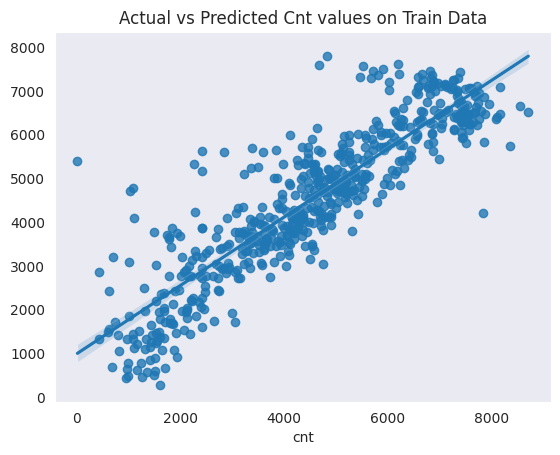

In [66]:
plt.figure()
plt.title("Actual vs Predicted Cnt values on Train Data")
sns.regplot(x=y_train, y =y_train_pred)
plt.show()

In [67]:
#checking the r2_score of actual vs predicted y values from the training set
r2_score(y_train,y_train_pred)

0.7819417778097163

**Actual and predicted is almost same - The model is good with a R2_Score of .7819 **

SUMMARY OF ACCURACY OF TRAIN MODEL

- Actual and predicted is almost same - The model is good
- R2 score of y_train vs y_train_pred is almost same as model R2 score


NOW LETS RUN OUR MODEL ON TEST DATA 

In [68]:
# scale variables of numerical on the test data
# do not fit only transform on test data
data_test[numeric_features] = scaler.transform(data_test[numeric_features])

In [69]:
y_test = data_test.pop('cnt')
X_test = data_test

In [70]:
y_test_pred = lr.predict(X_test[cols])

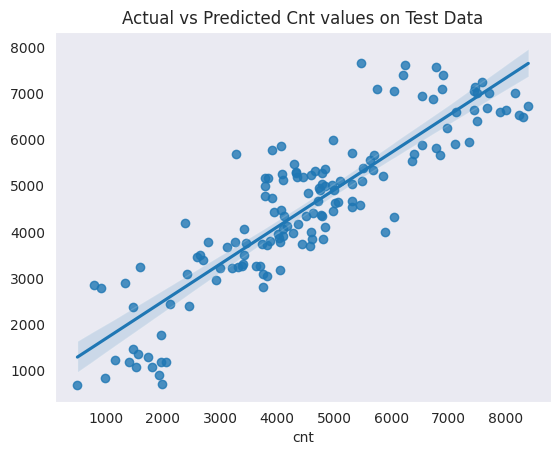

In [71]:
plt.figure()
plt.title("Actual vs Predicted Cnt values on Test Data")
sns.regplot(x=y_test, y =y_test_pred)
plt.show()

The model is good enough to predict the target on test data and the points are closely hugging the regression line. Lets check the r2_score on the test data predictions

In [72]:
#checking the r2_score of actual vs predicted y values from the test set
r2_score(y_test,y_test_pred)

0.7759901851504777

In [73]:
difference_r2_score = r2_score(y_train,y_train_pred) - r2_score(y_test,y_test_pred)
difference_r2_score

0.005951592659238614

<u>**SUMMARY OF ACCURACY OF TEST SET**</u>

- Actual and predicted is almost same on test data
- R2 score of y_test vs y_test_cnt is almost same but has slight variation of **.00595 (ie; 0.5 %)** which is exceptable when compared with R2 score of model

<u>**MODEL ASSUMPTION VALIDATIONS**</u>

<u>**1) Error Terms must be normally distributed with mean centered to 0 **</u>

    We will calculate the residuals sum of squares and plot them in distplot to prove the error terms are normally distributed

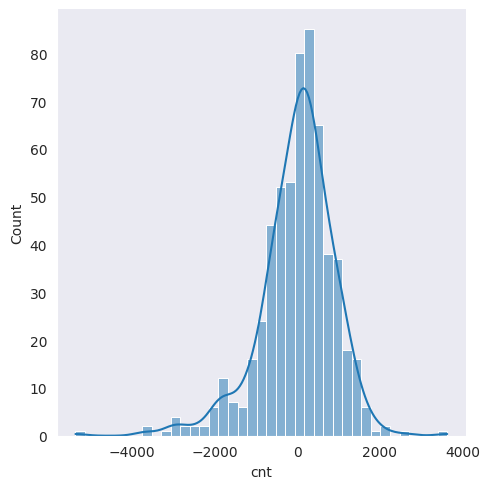

In [74]:
# calculate the residuals and plot 

res = y_train - y_train_pred
sns.displot(res, kde = True)


- Errors are normally distributed is indicated by mean is 0
- Error terms are randomly distributed and there is no pattern which means the output is explained well by the model and there are no other parameters that can explain the model better.

<u>**2) CHECK FOR MULTICOLLINEARITY**</u>

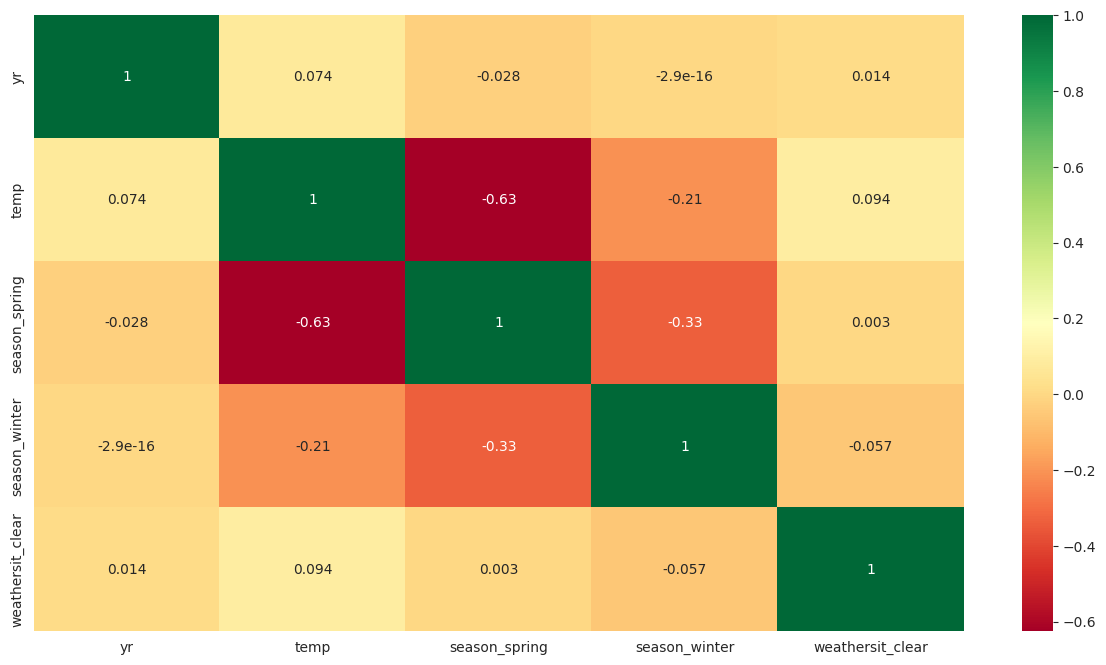

In [75]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train[cols].corr(),annot = True, cmap="RdYlGn")
plt.show()

Collinearity is less and correlation has dropped

In [79]:
vif_test = calcualte_vif(X_test[cols])
vif_test

,Features,VIF
1,temp,2.94
4,weathersit_clear,2.89
0,yr,1.85
2,season_spring,1.24
3,season_winter,1.18


VIF is well in control , ensuring the multicollinearity is not present

<u>**3) CHECK FOR HOMOSCEDASCITY OF ERROR TERMSS -- Error Terms should have equal varaiance**</u>

Text(0, 0.5, 'Error -ycnt-ytest')

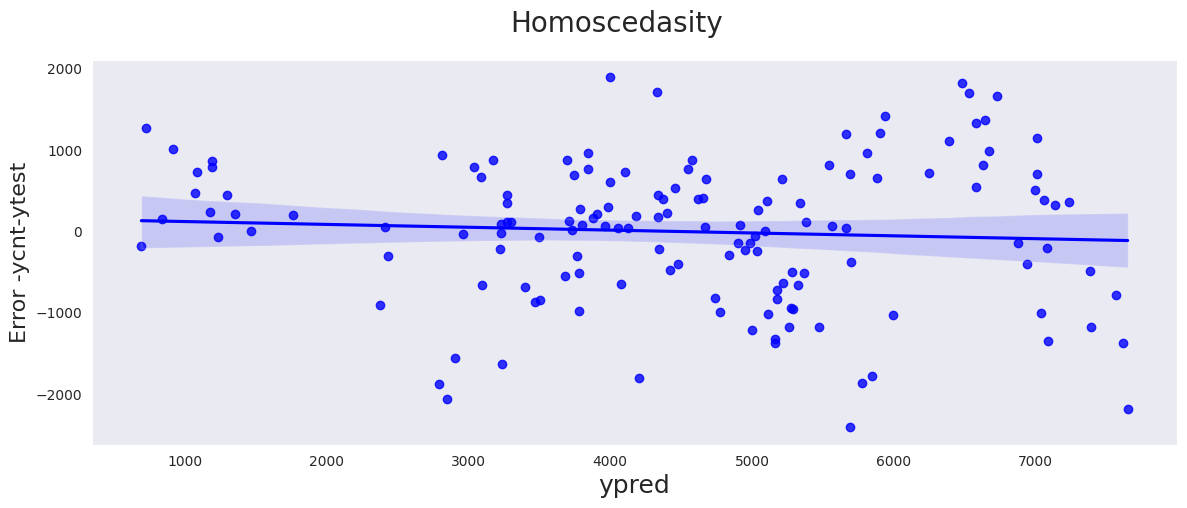

In [76]:
fig = plt.figure(figsize=(14,5))
res_test = y_test-y_test_pred
sns.regplot(x=y_test_pred, y=res_test, color="blue", marker='o')
fig.suptitle('Homoscedasity', fontsize=20)              
plt.xlabel('ypred', fontsize=18)                     
plt.ylabel('Error -ycnt-ytest', fontsize=16)

HOMSCEDASTICITY IS TRUE

**4) LINEARITY**

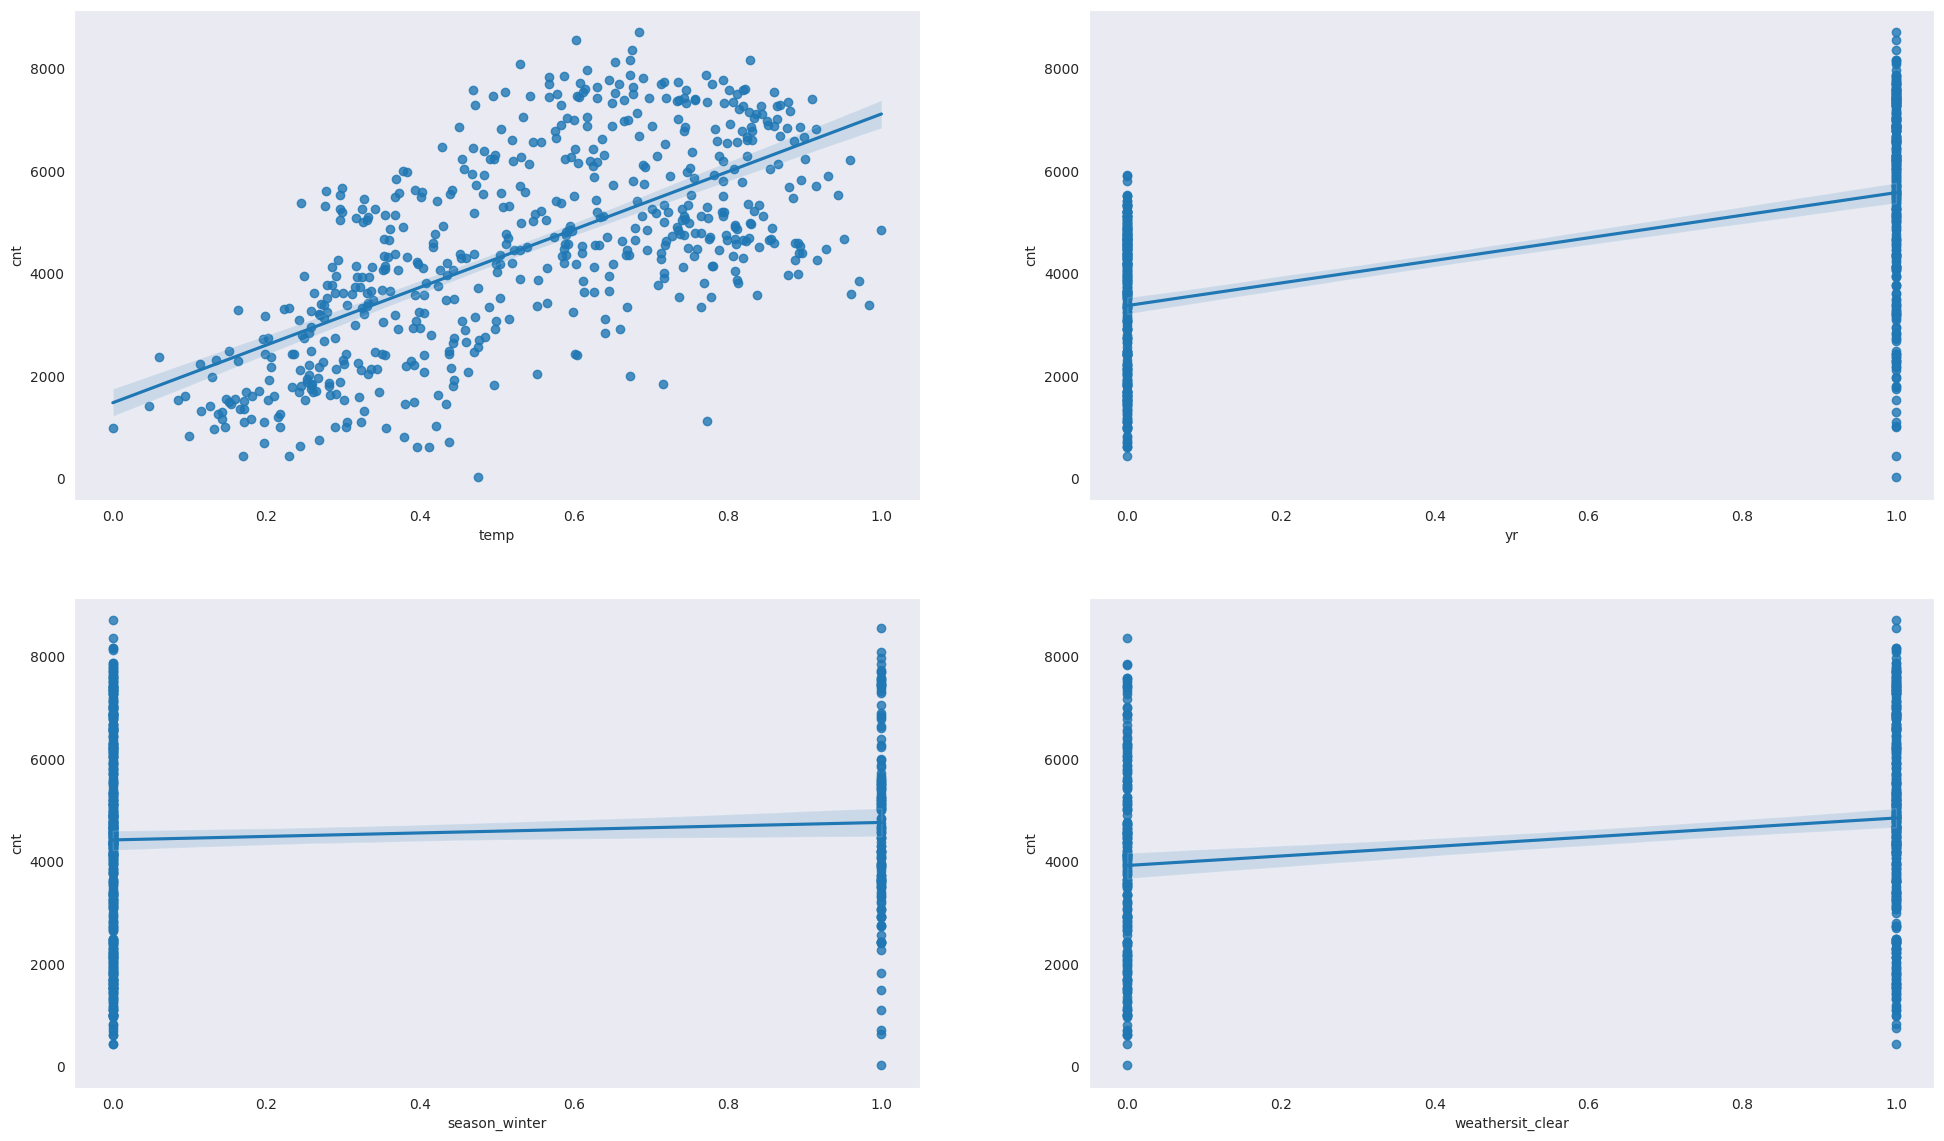

In [77]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(24, 14))

sns.regplot(x = X_train["temp"], y = y_train,ax=ax[0][0])
sns.regplot(x = X_train["yr"], y = y_train,ax=ax[0][1])
sns.regplot(x = X_train["season_winter"], y = y_train,ax=ax[1][0])
sns.regplot(x = X_train["weathersit_clear"], y = y_train,ax=ax[1][1])

plt.show()

The is linear relationship between dependent variable (cnt) to all model selected independent variables as shown.

<u>**INFERENCES ON ASSUMPTION**</u>

All the 4 assumptions of multiple linear regression are abided by the data

<u>**INTERPRETATION**</u>

The top 4 influence on the bike booking /demand

- temp : A coefficient value of   4017.586 indicated that a unit increase in temp variable increases the bike demand by same number, provided all other variables are held constant

- season_winter : A coefficient value of 459.0835 indicated that a unit increase in season_winter variable increases the bike demand by same number, provided all other variables are held constant

- weathersit_clear : A coefficient value of 747.949 indicated that a unit increase in weathersit_clear variable increases the bike demand by same number, provided all other variables are held constant

- yr : A coefficient value of 2033.1428 indicated that a unit increase in yr variable increases the bike demand by same number, provided all other variables are held constant

No visible trend or pattern